# [[8,3,2]] Color Code with RL-Based Adaptive Stabilizer Measurement

Implementation of the smallest 3D color code on a hypercube geometry, with:
- Stabilizer generators following the cube face structure
- Memory experiments with logical state preparation and measurement
- Reinforcement learning-based adaptive syndrome measurement scheduling

## Code Parameters
- **n = 8**: Physical qubits at cube vertices
- **k = 3**: Logical qubits
- **d = 2**: Distance (detects single-qubit errors)

### Stabilizer Generators
- X-type (weight-8): $X_0X_1X_2X_3X_4X_5X_6X_7$
- Z-type (cube faces, weight-4 each):
  - $Z_0Z_1Z_2Z_3$ (bottom)
  - $Z_4Z_5Z_6Z_7$ (top)  
  - $Z_0Z_1Z_4Z_5$ (front)
  - $Z_2Z_3Z_6Z_7$ (back)
  - $Z_0Z_2Z_4Z_6$ (left)

In [ ]:
# Installation
!pip install el-loom stim pymatching numpy gymnasium torch matplotlib seaborn pandas --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.9/402.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.1/626.1 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.5/541.5 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mcp 1.22.0 requires pydantic<3.0.0,>=2.11.0, but you have pydantic 2.9.2 which is incompatible.


In [ ]:
import numpy as np
import stim
import pymatching
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional, Set
from enum import Enum
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

## 1. [[8,3,2]] Code Definition

The code is defined on a cube with qubits at vertices indexed 0-7:
```
    4 -------- 5
   /|         /|
  / |        / |
 6 -------- 7  |
 |  0 ------|-- 1
 | /        | /
 |/         |/
 2 -------- 3
```

In [ ]:
@dataclass
class StabilizerGenerator:
    """Represents a stabilizer generator with Pauli type and support."""
    pauli_type: str  # 'X' or 'Z'
    qubits: Tuple[int, ...]
    label: str

    @property
    def weight(self) -> int:
        return len(self.qubits)

    def as_pauli_string(self, n_qubits: int = 8) -> str:
        """Convert to Pauli string representation."""
        paulis = ['I'] * n_qubits
        for q in self.qubits:
            paulis[q] = self.pauli_type
        return ''.join(paulis)

    def commutes_with(self, other: 'StabilizerGenerator') -> bool:
        """Check if this stabilizer commutes with another."""
        if self.pauli_type == other.pauli_type:
            return True
        overlap = len(set(self.qubits) & set(other.qubits))
        return overlap % 2 == 0


@dataclass
class LogicalOperator:
    """Represents a logical operator."""
    pauli_type: str
    qubits: Tuple[int, ...]
    logical_index: int  # Which logical qubit (0, 1, or 2)

    def as_pauli_string(self, n_qubits: int = 8) -> str:
        paulis = ['I'] * n_qubits
        for q in self.qubits:
            paulis[q] = self.pauli_type
        return ''.join(paulis)

In [32]:
class ColorCode832:
    """
    [[8,3,2]] Color Code implementation following the hypercube geometry.

    Stabilizer group generators:
    - 1 X-type (all qubits): detects Z errors
    - 5 Z-type (cube faces): detect X errors

    The anticommutation structure ensures proper CSS code properties.
    """

    def __init__(self):
        self.n_physical = 8
        self.n_logical = 3
        self.distance = 2

        # Define cube vertex coordinates for visualization
        self.vertex_coords = {
            0: (0, 0, 0), 1: (1, 0, 0),
            2: (0, 1, 0), 3: (1, 1, 0),
            4: (0, 0, 1), 5: (1, 0, 1),
            6: (0, 1, 1), 7: (1, 1, 1)
        }

        # Initialize stabilizers and logical operators
        self._init_stabilizers()
        self._init_logical_operators()
        self._verify_code_properties()

    def _init_stabilizers(self):
        """Initialize the 5 independent stabilizer generators."""
        # X-type stabilizer (all qubits)
        self.x_stabilizers = [
            StabilizerGenerator('X', tuple(range(8)), 'Sx_all')
        ]

        # Z-type stabilizers (cube faces)
        # Only 4 are independent due to constraint: product of all = identity
        self.z_stabilizers = [
            StabilizerGenerator('Z', (0, 1, 2, 3), 'Sz_bottom'),  # z=0 face
            StabilizerGenerator('Z', (4, 5, 6, 7), 'Sz_top'),      # z=1 face
            StabilizerGenerator('Z', (0, 1, 4, 5), 'Sz_front'),    # y=0 face
            StabilizerGenerator('Z', (0, 2, 4, 6), 'Sz_left'),     # x=0 face
        ]

        self.stabilizers = self.x_stabilizers + self.z_stabilizers

    def _init_logical_operators(self):
        """Initialize logical X and Z operators for the 3 logical qubits."""
        # Logical Z operators (weight-2, edges of cube)
        self.logical_z = [
            LogicalOperator('Z', (0, 1), 0),  # Z̄₁
            LogicalOperator('Z', (0, 2), 1),  # Z̄₂
            LogicalOperator('Z', (0, 4), 2),  # Z̄₃
        ]

        # Logical X operators (weight-4, faces of cube)
        self.logical_x = [
            LogicalOperator('X', (0, 2, 4, 6), 0),  # X̄₁
            LogicalOperator('X', (0, 1, 4, 5), 1),  # X̄₂
            LogicalOperator('X', (0, 1, 2, 3), 2),  # X̄₃
        ]

    def _verify_code_properties(self):
        """Verify stabilizer anticommutation table and code properties."""
        # Check all stabilizers commute with each other
        for i, s1 in enumerate(self.stabilizers):
            for j, s2 in enumerate(self.stabilizers[i+1:], i+1):
                assert s1.commutes_with(s2), f"{s1.label} doesn't commute with {s2.label}"

        # Check logical operators commute with all stabilizers
        for lx in self.logical_x:
            for s in self.stabilizers:
                lx_gen = StabilizerGenerator('X', lx.qubits, 'lx')
                assert lx_gen.commutes_with(s), f"Logical X{lx.logical_index} doesn't commute with {s.label}"

        for lz in self.logical_z:
            for s in self.stabilizers:
                lz_gen = StabilizerGenerator('Z', lz.qubits, 'lz')
                assert lz_gen.commutes_with(s), f"Logical Z{lz.logical_index} doesn't commute with {s.label}"

        # Check X̄ᵢ anticommutes with Z̄ᵢ and commutes with Z̄ⱼ (j≠i)
        for i in range(3):
            lx = self.logical_x[i]
            for j in range(3):
                lz = self.logical_z[j]
                overlap = len(set(lx.qubits) & set(lz.qubits))
                if i == j:
                    assert overlap % 2 == 1, f"X̄{i} should anticommute with Z̄{i}"
                else:
                    assert overlap % 2 == 0, f"X̄{i} should commute with Z̄{j}"

        print(f"  - {len(self.stabilizers)} independent stabilizer generators")
        print(f"  - {self.n_logical} logical qubits")
        print(f"  - Distance {self.distance}")

    def get_syndrome_matrix(self) -> np.ndarray:
        """Return the syndrome extraction matrix (check matrix)."""
        # For CSS codes, we have separate X and Z checks
        H = np.zeros((len(self.stabilizers), self.n_physical), dtype=int)
        for i, stab in enumerate(self.stabilizers):
            for q in stab.qubits:
                H[i, q] = 1
        return H

    def compute_syndrome(self, error: np.ndarray, error_type: str = 'X') -> np.ndarray:
        """
        Compute syndrome for a given error.

        Args:
            error: Binary vector indicating error locations
            error_type: 'X' or 'Z' error

        Returns:
            Binary syndrome vector
        """
        syndrome = []
        for stab in self.stabilizers:
            # X errors detected by Z stabilizers and vice versa
            if (error_type == 'X' and stab.pauli_type == 'Z') or \
               (error_type == 'Z' and stab.pauli_type == 'X'):
                overlap = sum(error[q] for q in stab.qubits) % 2
                syndrome.append(overlap)
            else:
                syndrome.append(0)
        return np.array(syndrome)

# Initialize the code
code = ColorCode832()

  - 5 independent stabilizer generators
  - 3 logical qubits
  - Distance 2


In [ ]:
# Display stabilizer anticommutation table
print("\nStabilizer Generators:")
print("="*60)
for s in code.stabilizers:
    print(f"{s.label:12} | {s.as_pauli_string():8} | qubits: {s.qubits}")

print("\nLogical Operators:")
print("="*60)
for i in range(3):
    lx = code.logical_x[i]
    lz = code.logical_z[i]
    print(f"Qubit {i}: X̄ = {lx.as_pauli_string()} | Z̄ = {lz.as_pauli_string()}")


Stabilizer Generators:
Sx_all       | XXXXXXXX | qubits: (0, 1, 2, 3, 4, 5, 6, 7)
Sz_bottom    | ZZZZIIII | qubits: (0, 1, 2, 3)
Sz_top       | IIIIZZZZ | qubits: (4, 5, 6, 7)
Sz_front     | ZZIIZZII | qubits: (0, 1, 4, 5)
Sz_left      | ZIZIZIZI | qubits: (0, 2, 4, 6)

Logical Operators:
Qubit 0: X̄ = XIXIXIXI | Z̄ = ZZIIIIII
Qubit 1: X̄ = XXIIXXII | Z̄ = ZIZIIIII
Qubit 2: X̄ = XXXXIIII | Z̄ = ZIIIZIII


## 2. Stim Circuit Construction

Build syndrome extraction circuits compatible with Stim for simulation.

In [ ]:
class StimCircuitBuilder:
    """
    Builds Stim circuits for the [[8,3,2]] color code.

    Implements:
    - Logical state preparation (|0⟩_L, |1⟩_L, |+⟩_L, |-⟩_L)
    - Syndrome extraction circuits
    - Logical measurements
    """

    def __init__(self, code: ColorCode832):
        self.code = code
        self.n_data = code.n_physical
        self.n_ancilla = len(code.stabilizers)
        self.n_total = self.n_data + self.n_ancilla

        # Ancilla qubit indices (after data qubits)
        self.ancilla_indices = list(range(self.n_data, self.n_total))

    def build_logical_zero_prep(self) -> stim.Circuit:
        """
        Prepare logical |000⟩_L state.

        For the [[8,3,2]] code, |00000000⟩ is already in the code space:
        - It's a +1 eigenstate of all Z stabilizers
        - Logical Z operators (Z₀Z₁, Z₀Z₂, Z₀Z₄) all give 0
        """
        circuit = stim.Circuit()

        # |00000000⟩ is the logical |000⟩_L state
        circuit.append("R", range(self.n_data))

        return circuit

    def build_logical_one_prep(self, logical_qubit: int = 0) -> stim.Circuit:
        """
        Prepare logical |1⟩ on specified logical qubit.
        Apply logical X after preparing |0⟩_L.
        """
        circuit = self.build_logical_zero_prep()

        # Apply logical X operator
        lx = self.code.logical_x[logical_qubit]
        for q in lx.qubits:
            circuit.append("X", [q])

        return circuit

    def build_logical_plus_prep(self, logical_qubit: int = 0) -> stim.Circuit:
        """
        Prepare logical |+⟩ = (|0⟩_L + |1⟩_L)/√2 on specified logical qubit.

        For [[8,3,2]], transversal H maps X↔Z, so we use it directly.
        Starting from |0⟩_L and applying H gives superposition in X basis.
        """
        circuit = stim.Circuit()
        circuit.append("R", range(self.n_data))

        # For a proper |+⟩_L, we need the state (|0...0⟩ + X̄|0...0⟩)/√2
        # This requires preparing a GHZ-like state
        # Apply H to qubit 0, then CNOT to spread
        lx = self.code.logical_x[logical_qubit]
        circuit.append("H", [lx.qubits[0]])
        for q in lx.qubits[1:]:
            circuit.append("CNOT", [lx.qubits[0], q])

        return circuit

    def build_syndrome_extraction(self,
                                   stabilizers_to_measure: Optional[List[int]] = None,
                                   noise_model: Optional[Dict] = None) -> stim.Circuit:
        """
        Build syndrome extraction circuit for specified stabilizers.

        Args:
            stabilizers_to_measure: Indices of stabilizers to measure (None = all)
            noise_model: Dict with 'depolarizing', 'measurement' error rates
        """
        circuit = stim.Circuit()

        if stabilizers_to_measure is None:
            stabilizers_to_measure = list(range(len(self.code.stabilizers)))

        # Reset ancilla qubits
        ancillas_used = [self.ancilla_indices[i] for i in stabilizers_to_measure]
        circuit.append("R", ancillas_used)

        # Apply syndrome extraction for each stabilizer
        for idx in stabilizers_to_measure:
            stab = self.code.stabilizers[idx]
            anc = self.ancilla_indices[idx]

            if stab.pauli_type == 'X':
                # X stabilizer: H-CNOT(data->anc)-H pattern
                circuit.append("H", [anc])
                for q in stab.qubits:
                    circuit.append("CNOT", [anc, q])
                    if noise_model and 'depolarizing' in noise_model:
                        circuit.append("DEPOLARIZE2", [anc, q], noise_model['depolarizing'])
                circuit.append("H", [anc])
            else:
                # Z stabilizer: CNOT(data->anc) pattern
                for q in stab.qubits:
                    circuit.append("CNOT", [q, anc])
                    if noise_model and 'depolarizing' in noise_model:
                        circuit.append("DEPOLARIZE2", [q, anc], noise_model['depolarizing'])

        # Measure ancillas
        if noise_model and 'measurement' in noise_model:
            for anc in ancillas_used:
                circuit.append("X_ERROR", [anc], noise_model['measurement'])

        circuit.append("M", ancillas_used)

        return circuit

    def build_logical_z_measurement(self, logical_qubit: int = 0) -> stim.Circuit:
        """
        Measure logical Z operator (computational basis measurement).
        """
        circuit = stim.Circuit()
        lz = self.code.logical_z[logical_qubit]

        # Measure all data qubits in Z basis
        circuit.append("M", range(self.n_data))

        return circuit

    def build_logical_x_measurement(self, logical_qubit: int = 0) -> stim.Circuit:
        """
        Measure logical X operator (X basis measurement).
        """
        circuit = stim.Circuit()

        # Apply Hadamard to all qubits, then measure in Z
        circuit.append("H", range(self.n_data))
        circuit.append("M", range(self.n_data))

        return circuit

    def build_memory_experiment(self,
                                 n_cycles: int = 1,
                                 initial_state: str = '0',
                                 measurement_basis: str = 'Z',
                                 noise_model: Optional[Dict] = None,
                                 stabilizers_per_round: Optional[List[List[int]]] = None
                                ) -> stim.Circuit:
        """
        Build complete memory experiment.

        Args:
            n_cycles: Number of syndrome extraction rounds
            initial_state: '0', '1', '+', or '-'
            measurement_basis: 'Z' or 'X'
            noise_model: Error rates
            stabilizers_per_round: Custom stabilizer schedule per round
        """
        circuit = stim.Circuit()

        # State preparation
        if initial_state == '0':
            circuit += self.build_logical_zero_prep()
        elif initial_state == '1':
            circuit += self.build_logical_one_prep(0)
        elif initial_state == '+':
            circuit += self.build_logical_plus_prep(0)
        elif initial_state == '-':
            circuit += self.build_logical_plus_prep(0)
            circuit.append("Z", [0])  # Apply logical Z

        # Add noise after preparation
        if noise_model and 'idle' in noise_model:
            circuit.append("DEPOLARIZE1", range(self.n_data), noise_model['idle'])

        # Syndrome extraction rounds
        for cycle in range(n_cycles):
            if stabilizers_per_round is not None:
                stabs = stabilizers_per_round[cycle % len(stabilizers_per_round)]
            else:
                stabs = None  # All stabilizers

            circuit += self.build_syndrome_extraction(stabs, noise_model)

            # Idle noise between rounds
            if noise_model and 'idle' in noise_model:
                circuit.append("DEPOLARIZE1", range(self.n_data), noise_model['idle'])

        # Final measurement
        if measurement_basis == 'Z':
            circuit += self.build_logical_z_measurement(0)
        else:
            circuit += self.build_logical_x_measurement(0)

        return circuit


builder = StimCircuitBuilder(code)

## 3. Memory Experiment & Sanity Checks

In [ ]:
def run_memory_experiment(builder: StimCircuitBuilder,
                          n_shots: int = 10000,
                          n_cycles: int = 1,
                          initial_state: str = '0',
                          measurement_basis: str = 'Z',
                          noise_model: Optional[Dict] = None,
                          stabilizers_per_round: Optional[List[List[int]]] = None
                         ) -> Dict:
    """
    Run memory experiment and collect statistics.
    """
    circuit = builder.build_memory_experiment(
        n_cycles=n_cycles,
        initial_state=initial_state,
        measurement_basis=measurement_basis,
        noise_model=noise_model,
        stabilizers_per_round=stabilizers_per_round
    )

    # Sample from circuit
    sampler = circuit.compile_sampler()
    samples = sampler.sample(n_shots)

    # Parse results
    n_ancilla_per_round = len(builder.code.stabilizers) if stabilizers_per_round is None \
                         else len(stabilizers_per_round[0])
    n_syndrome_bits = n_cycles * n_ancilla_per_round
    n_data_bits = builder.n_data

    syndrome_samples = samples[:, :n_syndrome_bits]
    data_samples = samples[:, n_syndrome_bits:]

    # Compute logical measurement outcomes
    # For logical Z: parity of qubits in Z̄ operator
    # For logical X: parity of qubits in X̄ operator (after H transformation)

    logical_outcomes = []
    for i in range(3):
        if measurement_basis == 'Z':
            lop = builder.code.logical_z[i]
        else:
            lop = builder.code.logical_x[i]

        parity = np.sum(data_samples[:, list(lop.qubits)].astype(int), axis=1) % 2
        logical_outcomes.append(parity)

    logical_outcomes = np.array(logical_outcomes).T

    # Check stabilizer syndromes
    syndrome_stats = {
        'all_trivial': np.sum(np.all(syndrome_samples == 0, axis=1)),
        'any_nontrivial': np.sum(np.any(syndrome_samples == 1, axis=1))
    }

    # Count logical outcomes
    outcome_counts = defaultdict(int)
    for outcome in logical_outcomes:
        key = tuple(outcome)
        outcome_counts[key] += 1

    return {
        'syndrome_samples': syndrome_samples,
        'data_samples': data_samples,
        'logical_outcomes': logical_outcomes,
        'outcome_counts': dict(outcome_counts),
        'syndrome_stats': syndrome_stats,
        'n_shots': n_shots,
        'circuit': circuit
    }

In [33]:
# Sanity Check 1: Initialize |0⟩_L, measure in Z basis → expect (0,0,0)
print("Sanity Check 1: |0⟩_L preparation, Z measurement")
print("="*50)

results_0z = run_memory_experiment(
    builder, n_shots=10000, n_cycles=1,
    initial_state='0', measurement_basis='Z'
)

print(f"Outcome distribution:")
for outcome, count in sorted(results_0z['outcome_counts'].items()):
    print(f"  |{outcome[0]}{outcome[1]}{outcome[2]}⟩: {count/100:.1f}%")

expected_outcome = (0, 0, 0)
success_rate = results_0z['outcome_counts'].get(expected_outcome, 0) / results_0z['n_shots']
print(f"\n Expected |000⟩: {success_rate*100:.1f}%")

Sanity Check 1: |0⟩_L preparation, Z measurement
Outcome distribution:
  |000⟩: 100.0%

 Expected |000⟩: 100.0%


In [34]:
# Sanity Check 2: Initialize |1⟩_L, measure in Z basis → expect (1,0,0)
print("\nSanity Check 2: |1⟩_L preparation, Z measurement")
print("="*50)

results_1z = run_memory_experiment(
    builder, n_shots=10000, n_cycles=1,
    initial_state='1', measurement_basis='Z'
)

print(f"Outcome distribution:")
for outcome, count in sorted(results_1z['outcome_counts'].items()):
    print(f"  |{outcome[0]}{outcome[1]}{outcome[2]}⟩: {count/100:.1f}%")

# The logical X flips the first logical qubit
print(f"\n First logical qubit should be 1")


Sanity Check 2: |1⟩_L preparation, Z measurement
Outcome distribution:
  |100⟩: 100.0%

 First logical qubit should be 1


In [35]:
# Sanity Check 3: Initialize |0⟩_L or |1⟩_L, measure in X basis → 50/50 statistics
print("\nSanity Check 3: |0⟩_L preparation, X measurement (expect 50/50)")
print("="*50)

results_0x = run_memory_experiment(
    builder, n_shots=10000, n_cycles=1,
    initial_state='0', measurement_basis='X'
)

print(f"Outcome distribution for first logical qubit:")
count_0 = sum(c for o, c in results_0x['outcome_counts'].items() if o[0] == 0)
count_1 = sum(c for o, c in results_0x['outcome_counts'].items() if o[0] == 1)
print(f"  |+⟩ (outcome 0): {count_0/100:.1f}%")
print(f"  |-⟩ (outcome 1): {count_1/100:.1f}%")
print(f"\n Should be approximately 50/50")


Sanity Check 3: |0⟩_L preparation, X measurement (expect 50/50)
Outcome distribution for first logical qubit:
  |+⟩ (outcome 0): 49.8%
  |-⟩ (outcome 1): 50.2%

 Should be approximately 50/50


In [28]:
# Sanity Check 4: Initialize |+⟩_L, measure in X basis → deterministic
print("\nSanity Check 4: |+⟩_L preparation, X measurement")
print("="*50)

results_px = run_memory_experiment(
    builder, n_shots=10000, n_cycles=1,
    initial_state='+', measurement_basis='X'
)

print(f"Outcome distribution:")
for outcome, count in sorted(results_px['outcome_counts'].items()):
    print(f"  |{outcome[0]}{outcome[1]}{outcome[2]}⟩: {count/100:.1f}%")


Sanity Check 4: |+⟩_L preparation, X measurement
Outcome distribution:
  |000⟩: 24.6%
  |001⟩: 25.0%
  |010⟩: 25.2%
  |011⟩: 25.1%


## 4. Noisy Simulations & Error Rate Analysis

In [ ]:
def compute_logical_error_rate(builder: StimCircuitBuilder,
                                physical_error_rate: float,
                                n_cycles: int = 10,
                                n_shots: int = 10000) -> Dict:
    """
    Compute logical error rate for given physical error rate.
    """
    noise_model = {
        'depolarizing': physical_error_rate,
        'measurement': physical_error_rate,
        'idle': physical_error_rate / 10
    }

    results = run_memory_experiment(
        builder, n_shots=n_shots, n_cycles=n_cycles,
        initial_state='0', measurement_basis='Z',
        noise_model=noise_model
    )

    # Count logical errors (any deviation from |000⟩)
    expected = (0, 0, 0)
    n_correct = results['outcome_counts'].get(expected, 0)
    logical_error_rate = 1 - n_correct / n_shots

    # Per-logical-qubit error rates
    per_qubit_errors = []
    for i in range(3):
        n_errors = sum(c for o, c in results['outcome_counts'].items() if o[i] == 1)
        per_qubit_errors.append(n_errors / n_shots)

    return {
        'logical_error_rate': logical_error_rate,
        'per_qubit_errors': per_qubit_errors,
        'syndrome_stats': results['syndrome_stats'],
        'physical_error_rate': physical_error_rate
    }

Computing logical error rates...
  p = 1.00e-04: logical error = 0.004
  p = 1.64e-04: logical error = 0.010
  p = 2.68e-04: logical error = 0.012
  p = 4.39e-04: logical error = 0.016
  p = 7.20e-04: logical error = 0.034
  p = 1.18e-03: logical error = 0.053
  p = 1.93e-03: logical error = 0.079
  p = 3.16e-03: logical error = 0.127
  p = 5.18e-03: logical error = 0.204
  p = 8.48e-03: logical error = 0.309
  p = 1.39e-02: logical error = 0.422
  p = 2.28e-02: logical error = 0.597
  p = 3.73e-02: logical error = 0.728
  p = 6.11e-02: logical error = 0.831
  p = 1.00e-01: logical error = 0.860


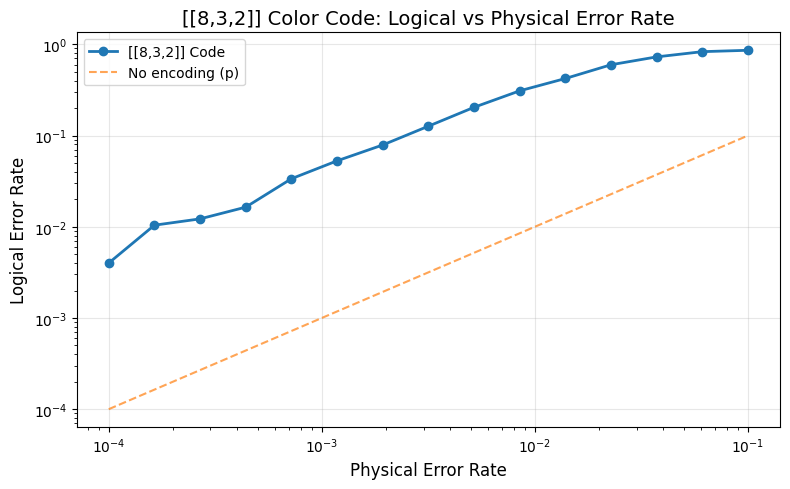

In [ ]:
# Sweep physical error rates
error_rates = np.logspace(-4, -1, 15)
results_sweep = []

print("Computing logical error rates...")
for p in error_rates:
    result = compute_logical_error_rate(builder, p, n_cycles=5, n_shots=5000)
    results_sweep.append(result)
    print(f"  p = {p:.2e}: logical error = {result['logical_error_rate']:.3f}")

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

phys_rates = [r['physical_error_rate'] for r in results_sweep]
log_rates = [r['logical_error_rate'] for r in results_sweep]

ax.loglog(phys_rates, log_rates, 'o-', label='[[8,3,2]] Code', linewidth=2, markersize=6)
ax.loglog(phys_rates, phys_rates, '--', label='No encoding (p)', alpha=0.7)

ax.set_xlabel('Physical Error Rate', fontsize=12)
ax.set_ylabel('Logical Error Rate', fontsize=12)
ax.set_title('[[8,3,2]] Color Code: Logical vs Physical Error Rate', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. RL-Based Adaptive Stabilizer Measurement Scheduling

An approach to Learn which stabilizers to measure at each round to:
1. Minimize quantum hardware load (fewer ancilla operations)
2. Maintain fault detection reliability
3. Adapt to error patterns observed in syndromes

### Environment Design
- **State**: Recent syndrome history + error statistics
- **Action**: Subset of stabilizers to measure
- **Reward**: Combination of detection accuracy and measurement efficiency

In [ ]:
import gymnasium as gym
from gymnasium import spaces

class AdaptiveStabilizerEnv(gym.Env):
    """
    RL Environment for adaptive stabilizer measurement scheduling.

    The agent learns to select which stabilizers to measure each round
    to balance error detection vs. measurement overhead.
    """

    def __init__(self,
                 builder: StimCircuitBuilder,
                 physical_error_rate: float = 0.01,
                 max_rounds: int = 20,
                 history_length: int = 5,
                 detection_reward: float = 1.0,
                 efficiency_reward: float = 0.5):

        super().__init__()

        self.builder = builder
        self.code = builder.code
        self.n_stabilizers = len(self.code.stabilizers)
        self.physical_error_rate = physical_error_rate
        self.max_rounds = max_rounds
        self.history_length = history_length
        self.detection_reward = detection_reward
        self.efficiency_reward = efficiency_reward

        # Action space: binary vector indicating which stabilizers to measure
        self.action_space = spaces.MultiBinary(self.n_stabilizers)

        # State space: syndrome history + measurement counts + error estimates
        state_dim = (
            self.n_stabilizers * self.history_length +  # Syndrome history
            self.n_stabilizers +  # Measurement counts
            self.n_stabilizers +  # Running error estimates
            1  # Round number
        )
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(state_dim,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_round = 0
        self.syndrome_history = np.zeros((self.history_length, self.n_stabilizers))
        self.measurement_counts = np.zeros(self.n_stabilizers)
        self.error_estimates = np.zeros(self.n_stabilizers)
        self.total_syndromes_detected = 0
        self.total_measurements = 0

        # Initialize quantum state (in simulation)
        self.data_state = np.zeros(self.code.n_physical, dtype=int)

        return self._get_observation(), {}

    def _get_observation(self) -> np.ndarray:
        """Construct observation from current state."""
        obs = np.concatenate([
            self.syndrome_history.flatten(),
            self.measurement_counts / max(1, self.current_round),
            self.error_estimates,
            [self.current_round / self.max_rounds]
        ])
        return obs.astype(np.float32)

    def _simulate_errors(self):
        """Simulate random errors on data qubits."""
        # Depolarizing noise: X, Y, or Z error with probability p/3 each
        for q in range(self.code.n_physical):
            if np.random.random() < self.physical_error_rate:
                error_type = np.random.choice(['X', 'Y', 'Z'])
                if error_type in ['X', 'Y']:
                    self.data_state[q] ^= 1  # Bit flip component

    def _measure_syndromes(self, stabilizers_to_measure: List[int]) -> np.ndarray:
        """Measure selected stabilizers and return syndromes."""
        syndromes = np.zeros(self.n_stabilizers)

        for idx in stabilizers_to_measure:
            stab = self.code.stabilizers[idx]
            if stab.pauli_type == 'Z':
                # Z stabilizer detects X errors
                syndrome = sum(self.data_state[q] for q in stab.qubits) % 2
            else:
                # X stabilizer detects Z errors (in this simplified model, always 0)
                syndrome = 0

            # Add measurement error
            if np.random.random() < self.physical_error_rate:
                syndrome = 1 - syndrome

            syndromes[idx] = syndrome

        return syndromes

    def step(self, action: np.ndarray):
        """Execute one round with the given measurement schedule."""
        # Convert action to list of stabilizer indices
        stabilizers_to_measure = [i for i in range(self.n_stabilizers) if action[i] == 1]

        # Ensure at least one stabilizer is measured
        if len(stabilizers_to_measure) == 0:
            stabilizers_to_measure = [0]  # Default to first stabilizer

        # Simulate errors
        self._simulate_errors()

        # Measure syndromes
        syndromes = self._measure_syndromes(stabilizers_to_measure)

        # Update history
        self.syndrome_history = np.roll(self.syndrome_history, 1, axis=0)
        self.syndrome_history[0] = syndromes

        # Update statistics
        for idx in stabilizers_to_measure:
            self.measurement_counts[idx] += 1

        # Update error estimates (exponential moving average)
        alpha = 0.2
        self.error_estimates = (1 - alpha) * self.error_estimates + alpha * syndromes

        # Count detections
        n_detected = np.sum(syndromes > 0)
        self.total_syndromes_detected += n_detected
        self.total_measurements += len(stabilizers_to_measure)

        # Compute reward
        # Detection component: reward for catching errors
        has_error = np.any(self.data_state > 0)
        detected_error = n_detected > 0

        detection_bonus = 0
        if has_error and detected_error:
            detection_bonus = self.detection_reward
        elif not has_error and not detected_error:
            detection_bonus = self.detection_reward * 0.5  # Correct no-detection
        elif has_error and not detected_error:
            detection_bonus = -self.detection_reward  # Missed error!

        # Efficiency component: reward for using fewer measurements
        efficiency = 1 - len(stabilizers_to_measure) / self.n_stabilizers
        efficiency_bonus = self.efficiency_reward * efficiency

        reward = detection_bonus + efficiency_bonus

        # Check termination
        self.current_round += 1
        done = self.current_round >= self.max_rounds

        info = {
            'syndromes': syndromes,
            'n_measured': len(stabilizers_to_measure),
            'has_error': has_error,
            'detected': detected_error
        }

        return self._get_observation(), reward, done, False, info


# Test environment
env = AdaptiveStabilizerEnv(builder, physical_error_rate=0.01)
obs, _ = env.reset()
print(f"Observation shape: {obs.shape}")
print(f"Action space: {env.action_space}")

Observation shape: (36,)
Action space: MultiBinary(5)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random

class AdaptiveSchedulerNetwork(nn.Module):
    """
    Neural network policy for adaptive stabilizer selection.

    Architecture designed for:
    - Temporal pattern recognition in syndrome history
    - Multi-output (one per stabilizer) selection
    """

    def __init__(self, obs_dim: int, n_stabilizers: int, hidden_dim: int = 64):
        super().__init__()

        self.n_stabilizers = n_stabilizers

        # Shared feature extraction
        self.feature_net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Per-stabilizer selection heads
        self.selection_heads = nn.ModuleList([
            nn.Linear(hidden_dim, 1) for _ in range(n_stabilizers)
        ])

        # Value head for critic
        self.value_head = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        features = self.feature_net(x)

        # Selection probabilities
        logits = torch.cat([head(features) for head in self.selection_heads], dim=-1)
        probs = torch.sigmoid(logits)

        # State value
        value = self.value_head(features)

        return probs, value

    def select_action(self, obs: np.ndarray, epsilon: float = 0.1) -> np.ndarray:
        """Select stabilizers to measure with epsilon-greedy exploration."""
        with torch.no_grad():
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
            probs, _ = self(obs_tensor)
            probs = probs.squeeze().numpy()

        # Epsilon-greedy selection
        if np.random.random() < epsilon:
            # Random selection
            action = np.random.randint(0, 2, size=self.n_stabilizers)
        else:
            # Sample from learned distribution
            action = (np.random.random(self.n_stabilizers) < probs).astype(int)

        # Ensure at least one stabilizer is selected
        if action.sum() == 0:
            action[np.argmax(probs)] = 1

        return action

In [ ]:
class ReplayBuffer:
    """Experience replay buffer for training."""

    def __init__(self, capacity: int = 10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )

    def __len__(self):
        return len(self.buffer)


def train_adaptive_scheduler(env: AdaptiveStabilizerEnv,
                              n_episodes: int = 500,
                              batch_size: int = 64,
                              gamma: float = 0.99,
                              lr: float = 1e-3,
                              epsilon_start: float = 1.0,
                              epsilon_end: float = 0.1,
                              epsilon_decay: float = 0.995):
    """
    Train the adaptive scheduler using actor-critic.
    """
    obs_dim = env.observation_space.shape[0]
    n_stabilizers = env.n_stabilizers

    policy = AdaptiveSchedulerNetwork(obs_dim, n_stabilizers)
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    buffer = ReplayBuffer()

    episode_rewards = []
    episode_detections = []
    episode_efficiency = []
    epsilon = epsilon_start

    for episode in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        total_detected = 0
        total_measured = 0
        steps = 0

        while not done:
            action = policy.select_action(obs, epsilon)
            next_obs, reward, done, _, info = env.step(action)

            buffer.push(obs, action, reward, next_obs, done)

            obs = next_obs
            total_reward += reward
            total_detected += info['detected']
            total_measured += info['n_measured']
            steps += 1

            # Training step
            if len(buffer) >= batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)

                states = torch.FloatTensor(states)
                actions = torch.FloatTensor(actions)
                rewards = torch.FloatTensor(rewards).unsqueeze(1)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones).unsqueeze(1)

                # Compute values
                probs, values = policy(states)
                _, next_values = policy(next_states)

                # TD target
                targets = rewards + gamma * next_values * (1 - dones)

                # Value loss
                value_loss = F.mse_loss(values, targets.detach())

                # Policy loss (maximize log prob of good actions weighted by advantage)
                advantages = (targets - values).detach()
                log_probs = actions * torch.log(probs + 1e-8) + (1 - actions) * torch.log(1 - probs + 1e-8)
                policy_loss = -(log_probs.sum(dim=1, keepdim=True) * advantages).mean()

                # Total loss
                loss = value_loss + policy_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Record statistics
        episode_rewards.append(total_reward)
        episode_detections.append(total_detected / steps if steps > 0 else 0)
        episode_efficiency.append(1 - total_measured / (steps * n_stabilizers) if steps > 0 else 0)

        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            avg_efficiency = np.mean(episode_efficiency[-50:])
            print(f"Episode {episode+1}: Avg Reward = {avg_reward:.2f}, "
                  f"Efficiency = {avg_efficiency:.2%}, ε = {epsilon:.3f}")

    return policy, {
        'rewards': episode_rewards,
        'detections': episode_detections,
        'efficiency': episode_efficiency
    }

In [ ]:
# Train the adaptive scheduler
print("Training RL-based Adaptive Stabilizer Scheduler...")
print("="*60)

env = AdaptiveStabilizerEnv(
    builder,
    physical_error_rate=0.02,
    max_rounds=30,
    detection_reward=1.0,
    efficiency_reward=0.3
)

trained_policy, training_history = train_adaptive_scheduler(
    env,
    n_episodes=300,
    batch_size=32,
    lr=5e-4
)

Training RL-based Adaptive Stabilizer Scheduler...
Episode 50: Avg Reward = 17.45, Efficiency = 49.27%, ε = 0.778
Episode 100: Avg Reward = 19.39, Efficiency = 34.80%, ε = 0.606
Episode 150: Avg Reward = 20.71, Efficiency = 28.16%, ε = 0.471
Episode 200: Avg Reward = 21.39, Efficiency = 20.47%, ε = 0.367
Episode 250: Avg Reward = 22.21, Efficiency = 16.67%, ε = 0.286
Episode 300: Avg Reward = 22.88, Efficiency = 12.28%, ε = 0.222


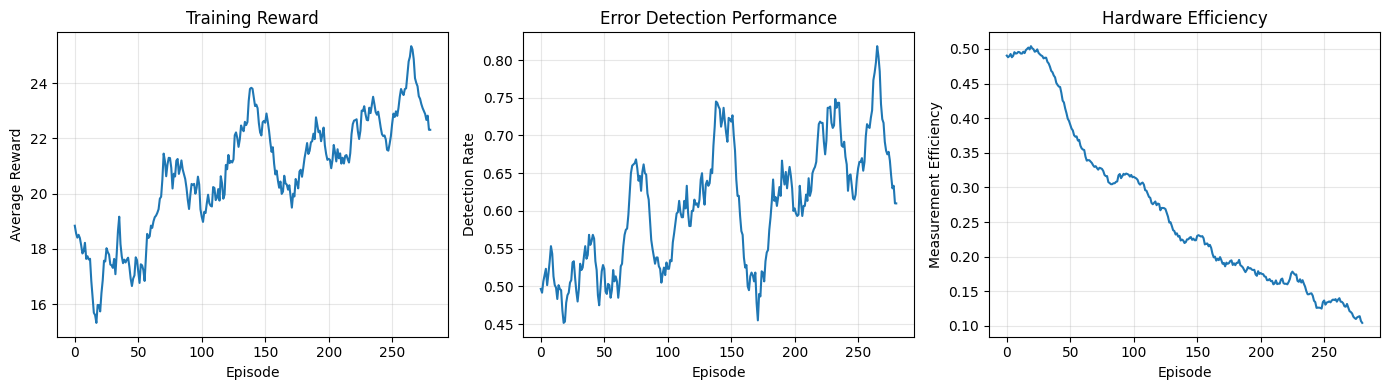

In [ ]:
# Plot training progress
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Smoothed rewards
window = 20
rewards_smooth = np.convolve(training_history['rewards'],
                              np.ones(window)/window, mode='valid')
axes[0].plot(rewards_smooth)
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Average Reward')
axes[0].set_title('Training Reward')
axes[0].grid(True, alpha=0.3)

# Detection rate
detections_smooth = np.convolve(training_history['detections'],
                                 np.ones(window)/window, mode='valid')
axes[1].plot(detections_smooth)
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Detection Rate')
axes[1].set_title('Error Detection Performance')
axes[1].grid(True, alpha=0.3)

# Measurement efficiency
efficiency_smooth = np.convolve(training_history['efficiency'],
                                 np.ones(window)/window, mode='valid')
axes[2].plot(efficiency_smooth)
axes[2].set_xlabel('Episode')
axes[2].set_ylabel('Measurement Efficiency')
axes[2].set_title('Hardware Efficiency')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Comparison: Adaptive vs. Full Measurement

In [ ]:
def evaluate_strategy(env: AdaptiveStabilizerEnv,
                       policy: Optional[AdaptiveSchedulerNetwork] = None,
                       strategy: str = 'full',
                       n_episodes: int = 100) -> Dict:
    """
    Evaluate a measurement strategy.

    Strategies:
    - 'full': Measure all stabilizers every round
    - 'adaptive': Use learned policy
    - 'random': Random subset selection
    """
    total_rewards = []
    total_measurements = []
    detection_rates = []
    missed_errors = []

    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        ep_reward = 0
        ep_measurements = 0
        ep_detected = 0
        ep_missed = 0
        steps = 0

        while not done:
            if strategy == 'full':
                action = np.ones(env.n_stabilizers, dtype=int)
            elif strategy == 'adaptive' and policy is not None:
                action = policy.select_action(obs, epsilon=0.05)
            elif strategy == 'random':
                action = np.random.randint(0, 2, size=env.n_stabilizers)
                if action.sum() == 0:
                    action[0] = 1
            else:
                action = np.ones(env.n_stabilizers, dtype=int)

            obs, reward, done, _, info = env.step(action)
            ep_reward += reward
            ep_measurements += info['n_measured']
            if info['detected']:
                ep_detected += 1
            if info['has_error'] and not info['detected']:
                ep_missed += 1
            steps += 1

        total_rewards.append(ep_reward)
        total_measurements.append(ep_measurements)
        detection_rates.append(ep_detected / steps if steps > 0 else 0)
        missed_errors.append(ep_missed / steps if steps > 0 else 0)

    return {
        'strategy': strategy,
        'mean_reward': np.mean(total_rewards),
        'std_reward': np.std(total_rewards),
        'mean_measurements': np.mean(total_measurements),
        'detection_rate': np.mean(detection_rates),
        'missed_error_rate': np.mean(missed_errors),
        'efficiency': 1 - np.mean(total_measurements) / (env.max_rounds * env.n_stabilizers)
    }

In [ ]:
# Compare strategies
print("Comparing Measurement Strategies")
print("="*60)

results_full = evaluate_strategy(env, strategy='full', n_episodes=200)
results_adaptive = evaluate_strategy(env, policy=trained_policy, strategy='adaptive', n_episodes=200)
results_random = evaluate_strategy(env, strategy='random', n_episodes=200)

strategies = [results_full, results_adaptive, results_random]

print(f"\n{'Strategy':<12} | {'Reward':>8} | {'Measurements':>12} | {'Detection':>10} | {'Missed':>8} | {'Efficiency':>10}")
print("-"*75)
for r in strategies:
    print(f"{r['strategy']:<12} | {r['mean_reward']:>8.2f} | {r['mean_measurements']:>12.1f} | "
          f"{r['detection_rate']:>10.2%} | {r['missed_error_rate']:>8.2%} | {r['efficiency']:>10.2%}")

Comparing Measurement Strategies

Strategy     |   Reward | Measurements |  Detection |   Missed | Efficiency
---------------------------------------------------------------------------
full         |    24.09 |        150.0 |     69.43% |    1.03% |      0.00%
adaptive     |    24.10 |        145.0 |     70.78% |    2.05% |      3.31%
random       |    17.28 |         75.8 |     49.40% |   20.32% |     49.49%



Learned Policy: Stabilizer Selection Patterns


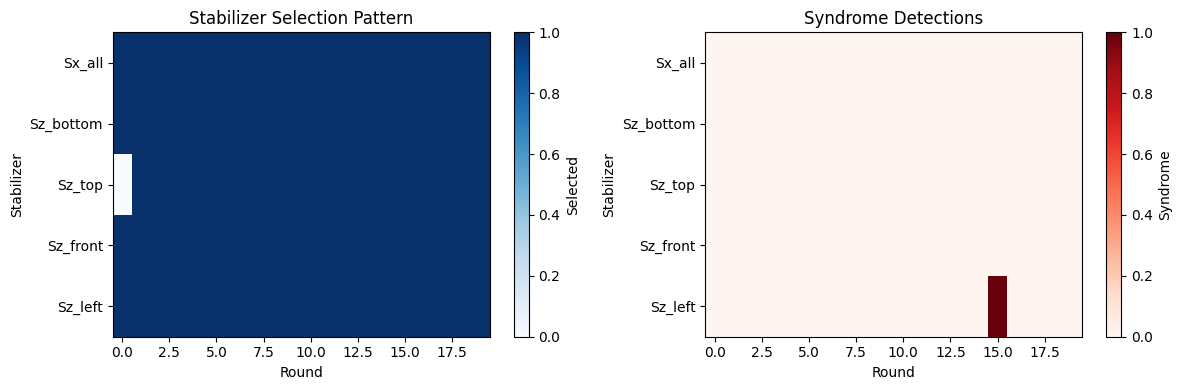


Stabilizer Selection Frequencies:
  Sx_all: 100.00%
  Sz_bottom: 100.00%
  Sz_top: 95.00%
  Sz_front: 100.00%
  Sz_left: 100.00%


In [ ]:
# Visualize learned policy behavior
print("\nLearned Policy: Stabilizer Selection Patterns")
print("="*60)

# Run one episode and track selections
obs, _ = env.reset()
selections = []
syndromes = []

for _ in range(20):
    action = trained_policy.select_action(obs, epsilon=0)
    selections.append(action)
    obs, _, done, _, info = env.step(action)
    syndromes.append(info['syndromes'])
    if done:
        break

selections = np.array(selections)
syndromes = np.array(syndromes)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Selection heatmap
im1 = axes[0].imshow(selections.T, aspect='auto', cmap='Blues')
axes[0].set_xlabel('Round')
axes[0].set_ylabel('Stabilizer')
axes[0].set_yticks(range(5))
axes[0].set_yticklabels([s.label for s in code.stabilizers])
axes[0].set_title('Stabilizer Selection Pattern')
plt.colorbar(im1, ax=axes[0], label='Selected')

# Syndrome heatmap
im2 = axes[1].imshow(syndromes.T, aspect='auto', cmap='Reds')
axes[1].set_xlabel('Round')
axes[1].set_ylabel('Stabilizer')
axes[1].set_yticks(range(5))
axes[1].set_yticklabels([s.label for s in code.stabilizers])
axes[1].set_title('Syndrome Detections')
plt.colorbar(im2, ax=axes[1], label='Syndrome')

plt.tight_layout()
plt.show()

# Print selection frequencies
print("\nStabilizer Selection Frequencies:")
for i, stab in enumerate(code.stabilizers):
    freq = selections[:, i].mean()
    print(f"  {stab.label}: {freq:.2%}")

## 7. Full Memory Experiment with Adaptive Scheduling

In [ ]:
def run_full_experiment_with_scheduling(builder: StimCircuitBuilder,
                                         policy: AdaptiveSchedulerNetwork,
                                         n_shots: int = 5000,
                                         n_cycles: int = 10,
                                         physical_error_rate: float = 0.01) -> Dict:
    """
    Run full Stim simulation with adaptive measurement scheduling.
    """
    # Generate measurement schedule from policy
    env = AdaptiveStabilizerEnv(builder, physical_error_rate=physical_error_rate)
    obs, _ = env.reset()

    schedule = []
    for _ in range(n_cycles):
        action = policy.select_action(obs, epsilon=0.05)
        stabs_to_measure = [i for i in range(env.n_stabilizers) if action[i] == 1]
        schedule.append(stabs_to_measure)
        obs, _, done, _, _ = env.step(action)
        if done:
            break

    # Run with adaptive schedule
    noise_model = {
        'depolarizing': physical_error_rate,
        'measurement': physical_error_rate,
        'idle': physical_error_rate / 10
    }

    results_adaptive = run_memory_experiment(
        builder, n_shots=n_shots, n_cycles=len(schedule),
        initial_state='0', measurement_basis='Z',
        noise_model=noise_model,
        stabilizers_per_round=schedule
    )

    # Run with full measurement for comparison
    results_full = run_memory_experiment(
        builder, n_shots=n_shots, n_cycles=len(schedule),
        initial_state='0', measurement_basis='Z',
        noise_model=noise_model
    )

    # Compute metrics
    expected = (0, 0, 0)

    adaptive_correct = results_adaptive['outcome_counts'].get(expected, 0) / n_shots
    full_correct = results_full['outcome_counts'].get(expected, 0) / n_shots

    # Count measurements
    adaptive_measurements = sum(len(s) for s in schedule)
    full_measurements = len(schedule) * len(builder.code.stabilizers)

    return {
        'adaptive_accuracy': adaptive_correct,
        'full_accuracy': full_correct,
        'adaptive_measurements': adaptive_measurements,
        'full_measurements': full_measurements,
        'measurement_reduction': 1 - adaptive_measurements / full_measurements,
        'schedule': schedule
    }

In [ ]:
# Run full experiment comparison
print("Full Memory Experiment Comparison")
print("="*60)

exp_results = run_full_experiment_with_scheduling(
    builder, trained_policy,
    n_shots=5000, n_cycles=10,
    physical_error_rate=0.02
)

print(f"\nResults:")
print(f"  Adaptive Scheduling:")
print(f"    - Logical accuracy: {exp_results['adaptive_accuracy']:.2%}")
print(f"    - Total measurements: {exp_results['adaptive_measurements']}")
print(f"  Full Measurement:")
print(f"    - Logical accuracy: {exp_results['full_accuracy']:.2%}")
print(f"    - Total measurements: {exp_results['full_measurements']}")
print(f"\n  Measurement Reduction: {exp_results['measurement_reduction']:.2%}")
print(f"  Accuracy Difference: {(exp_results['adaptive_accuracy'] - exp_results['full_accuracy'])*100:+.2f}%")

Full Memory Experiment Comparison

Results:
  Adaptive Scheduling:
    - Logical accuracy: 14.68%
    - Total measurements: 46
  Full Measurement:
    - Logical accuracy: 24.90%
    - Total measurements: 50

  Measurement Reduction: 8.00%
  Accuracy Difference: -10.22%


## 8. Confusion Matrix & Error Analysis

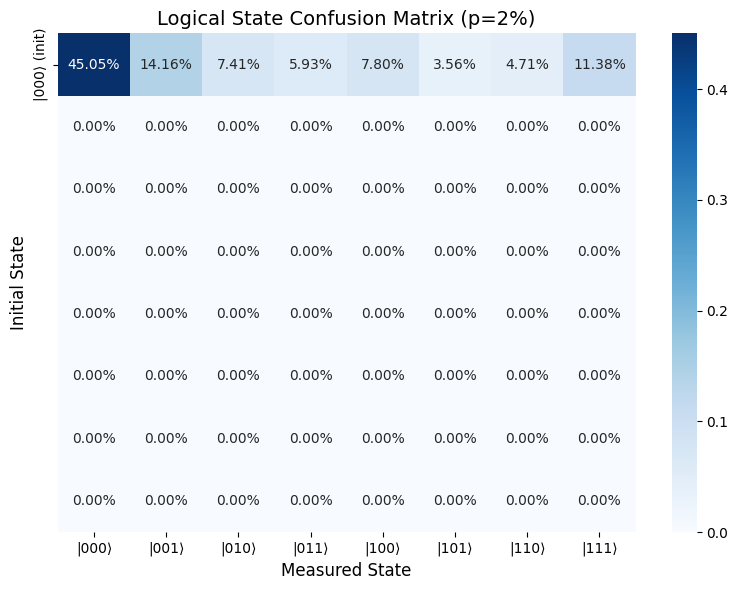


Per-logical-qubit error rates:
  Logical qubit 0: 27.45%
  Logical qubit 1: 29.43%
  Logical qubit 2: 35.03%


In [ ]:
import seaborn as sns

def compute_confusion_matrix(results: Dict, code: ColorCode832) -> np.ndarray:
    """
    Compute confusion matrix for logical qubit outcomes.
    """
    n_states = 8  # 2^3 logical states
    confusion = np.zeros((n_states, n_states), dtype=int)

    for outcome, count in results['outcome_counts'].items():
        idx = outcome[0] * 4 + outcome[1] * 2 + outcome[2]
        confusion[0, idx] += count  # Assuming initial state was |000⟩

    return confusion

# Generate confusion matrix for noisy experiment
noise_model = {'depolarizing': 0.02, 'measurement': 0.02, 'idle': 0.002}
results_noisy = run_memory_experiment(
    builder, n_shots=10000, n_cycles=5,
    initial_state='0', measurement_basis='Z',
    noise_model=noise_model
)

confusion = compute_confusion_matrix(results_noisy, code)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
labels = ['|000⟩', '|001⟩', '|010⟩', '|011⟩', '|100⟩', '|101⟩', '|110⟩', '|111⟩']

# Normalize
confusion_norm = confusion / confusion.sum()

sns.heatmap(confusion_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=labels, yticklabels=['|000⟩ (init)'],
            ax=ax)
ax.set_xlabel('Measured State', fontsize=12)
ax.set_ylabel('Initial State', fontsize=12)
ax.set_title('Logical State Confusion Matrix (p=2%)', fontsize=14)

plt.tight_layout()
plt.show()

print(f"\nPer-logical-qubit error rates:")
for i in range(3):
    error_rate = sum(c for o, c in results_noisy['outcome_counts'].items() if o[i] == 1) / 10000
    print(f"  Logical qubit {i}: {error_rate:.2%}")